# TASK 2a (Part 1): IMAGE CLASSIFICATION WITH CNN

---

### Dataset: 100 Sports Image Classification
- **Link**: https://www.kaggle.com/datasets/gpiosenka/sports-classification
- **Number of Images**: ~14,500 (13,493 train + 500 test + 500 validation)
- **Number of Classes**: 100 sports categories
- **Target Variable**: Sport type (e.g., basketball, soccer, tennis, swimming)

### Dataset Description
The dataset contains images of 100 different sports activities collected from internet sources. Images are preprocessed to 224×224 RGB format and organized into train/test/validation splits. The dataset covers diverse sports including ball sports (basketball, soccer, tennis), water sports (swimming, diving, surfing), combat sports (boxing, wrestling), winter sports (skiing, ice hockey), and track & field events (running, javelin).

### Optimization Techniques Applied:
1. Data Augmentation (rotation, shifts, flips, zoom)
2. Transfer Learning (VGG16 pre-trained on ImageNet)
3. Batch Normalization
4. Dropout Regularization
5. Learning Rate Scheduling
6. Early Stopping
7. Fine-tuning of pre-trained layers

---

In [ ]:
# Install required packages
!pip install -q tensorflow keras opendatasets matplotlib seaborn scikit-learn

In [ ]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Scikit-learn imports
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import label_binarize

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Download the Sports Classification Dataset from Kaggle
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/gpiosenka/sports-classification'
od.download(dataset_url)

print("Dataset downloaded successfully!")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abujamaldeen
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification


100%|██████████| 424M/424M [00:00<00:00, 1.67GB/s]



Dataset downloaded successfully!


In [ ]:
# Set up data directories
BASE_DIR = 'sports-classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VALID_DIR = os.path.join(BASE_DIR, 'valid')

# Count images function
def count_images(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return total

train_count = count_images(TRAIN_DIR)
valid_count = count_images(VALID_DIR)
test_count = count_images(TEST_DIR)
num_classes = len(os.listdir(TRAIN_DIR))

print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"Training images:   {train_count}")
print(f"Validation images: {valid_count}")
print(f"Test images:       {test_count}")
print(f"Total images:      {train_count + valid_count + test_count}")
print(f"Number of classes: {num_classes}")
print("="*60)

DATASET INFORMATION
Training images:   13492
Validation images: 500
Test images:       500
Total images:      14492
Number of classes: 100


In [ ]:
# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = num_classes

# OPTIMIZATION TECHNIQUE 1: Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation/test - only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print(f"\nSample classes: {class_names[:10]}...")

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.

Sample classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling']...


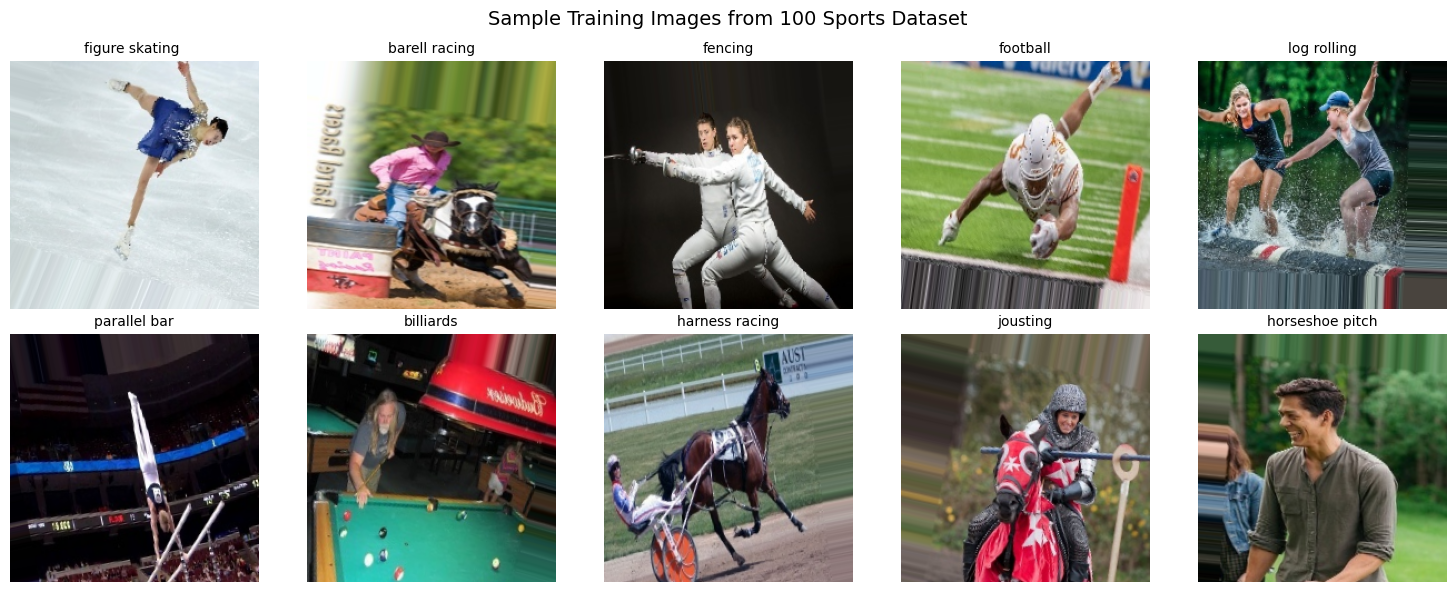

In [ ]:
# Visualize sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

images, labels = next(train_generator)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    class_idx = np.argmax(labels[i])
    ax.set_title(class_names[class_idx][:15], fontsize=10)
    ax.axis('off')

plt.suptitle('Sample Training Images from 100 Sports Dataset', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# OPTIMIZATION TECHNIQUE 2: Transfer Learning with VGG16
# Load pre-trained VGG16 without top classification layers
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze base model layers initially
base_model.trainable = False

# Build the complete model architecture
model_cnn = models.Sequential([
    # Pre-trained VGG16 base
    base_model,

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # OPTIMIZATION TECHNIQUE 3: Batch Normalization
    layers.BatchNormalization(),

    # Dense layers with dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # OPTIMIZATION TECHNIQUE 4: Dropout

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("\nMODEL ARCHITECTURE:")
model_cnn.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

MODEL ARCHITECTURE:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,136,420 (57.74 MB)

 Trainable params: 420,708 (1.60 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
# OPTIMIZATION TECHNIQUES 5 & 6: Callbacks for training

# Early Stopping - stop training when validation loss stops improving
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate Scheduler - reduce LR when validation loss plateaus
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Model Checkpoint - save best model
model_checkpoint = callbacks.ModelCheckpoint(
    'best_sports_cnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
# PHASE 1: Train only the top layers (base model frozen)
print("="*60)
print("PHASE 1: Training Top Layers (Base Model Frozen)")
print("="*60)

history_phase1 = model_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=1
)

PHASE 1: Training Top Layers (Base Model Frozen)
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.1111 - loss: 4.0588
Epoch 1: val_accuracy improved from -inf to 0.54800, saving model to best_sports_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 165s 368ms/step - accuracy: 0.1112 - loss: 4.0575 - val_accuracy: 0.5480 - val_loss: 2.1024 - learning_rate: 0.0010
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.3567 - loss: 2.5428
Epoch 2: val_accuracy improved from 0.54800 to 0.64200, saving model to best_sports_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 144s 340ms/step - accuracy: 0.3567 - loss: 2.5426 - val_accuracy: 0.6420 - val_loss: 1.3272 - learning_rate: 0.0010
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.4253 - loss: 2.1628
Epoch 3: val_accuracy improved from 0.64200 to 0.65800, saving model to best_sports_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 338ms/step - accuracy: 0.4253 - loss: 2.1628 - val_accuracy: 0.658

In [ ]:
# OPTIMIZATION TECHNIQUE 7: Fine-tuning
# Unfreeze the last 4 layers of the base model for fine-tuning
print("="*60)
print("PHASE 2: Fine-tuning (Unfreezing Last 4 Layers)")
print("="*60)

base_model.trainable = True

# Freeze all layers except the last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model_cnn.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_phase2 = model_cnn.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=1
)

PHASE 2: Fine-tuning (Unfreezing Last 4 Layers)
Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5958 - loss: 1.4691
Epoch 1: val_accuracy improved from 0.75000 to 0.76200, saving model to best_sports_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 156s 355ms/step - accuracy: 0.5958 - loss: 1.4690 - val_accuracy: 0.7620 - val_loss: 0.7360 - learning_rate: 1.0000e-05
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6257 - loss: 1.3209
Epoch 2: val_accuracy improved from 0.76200 to 0.77000, saving model to best_sports_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 144s 341ms/step - accuracy: 0.6257 - loss: 1.3208 - val_accuracy: 0.7700 - val_loss: 0.7459 - learning_rate: 1.0000e-05
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6568 - loss: 1.2288
Epoch 3: val_accuracy improved from 0.77000 to 0.77600, saving model to best_sports_cnn_model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 144s 341ms/step - accuracy: 0.6568 - loss: 1.2288 - val_accur

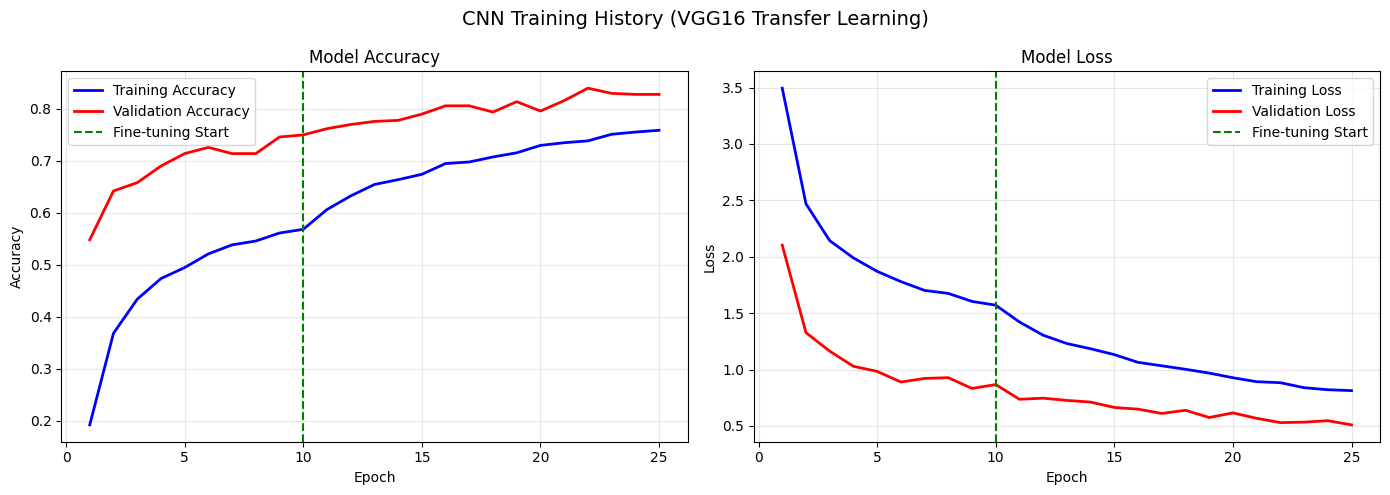

In [ ]:
# Plot training history (combining both phases)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combine histories from both phases
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

epochs_range = range(1, len(acc) + 1)
phase1_end = len(history_phase1.history['accuracy'])

# Accuracy plot
axes[0].plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=phase1_end, color='green', linestyle='--', label='Fine-tuning Start')
axes[0].set_title('Model Accuracy', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
axes[1].axvline(x=phase1_end, color='green', linestyle='--', label='Fine-tuning Start')
axes[1].set_title('Model Loss', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('CNN Training History (VGG16 Transfer Learning)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Load best model and evaluate on test set
print("Loading best model for evaluation...")
model_cnn = keras.models.load_model('best_sports_cnn_model.keras')

# Get predictions
test_generator.reset()
y_pred_proba = model_cnn.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_generator.classes

print(f"\nTotal test samples: {len(y_true)}")
print(f"Predictions shape: {y_pred_proba.shape}")

Loading best model for evaluation...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step

Total test samples: 500
Predictions shape: (500, 100)


In [ ]:
# Calculate all required metrics
cnn_accuracy = accuracy_score(y_true, y_pred)
cnn_precision = precision_score(y_true, y_pred, average='weighted')
cnn_recall = recall_score(y_true, y_pred, average='weighted')
cnn_f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate AUC (one-vs-rest for multiclass)
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
cnn_auc = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')

# Display results
print("\n" + "="*70)
print("CNN IMAGE CLASSIFICATION RESULTS")
print("Dataset: 100 Sports Image Classification")
print("="*70)
print(f"{'Metric':<15} {'Value':<10}")
print("-"*25)
print(f"{'Accuracy':<15} {cnn_accuracy:.4f}")
print(f"{'Precision':<15} {cnn_precision:.4f}")
print(f"{'Recall':<15} {cnn_recall:.4f}")
print(f"{'F1-Score':<15} {cnn_f1:.4f}")
print(f"{'AUC-ROC':<15} {cnn_auc:.4f}")
print("="*70)


CNN IMAGE CLASSIFICATION RESULTS
Dataset: 100 Sports Image Classification
Metric          Value     
-------------------------
Accuracy        0.9040
Precision       0.9180
Recall          0.9040
F1-Score        0.9004
AUC-ROC         0.9995


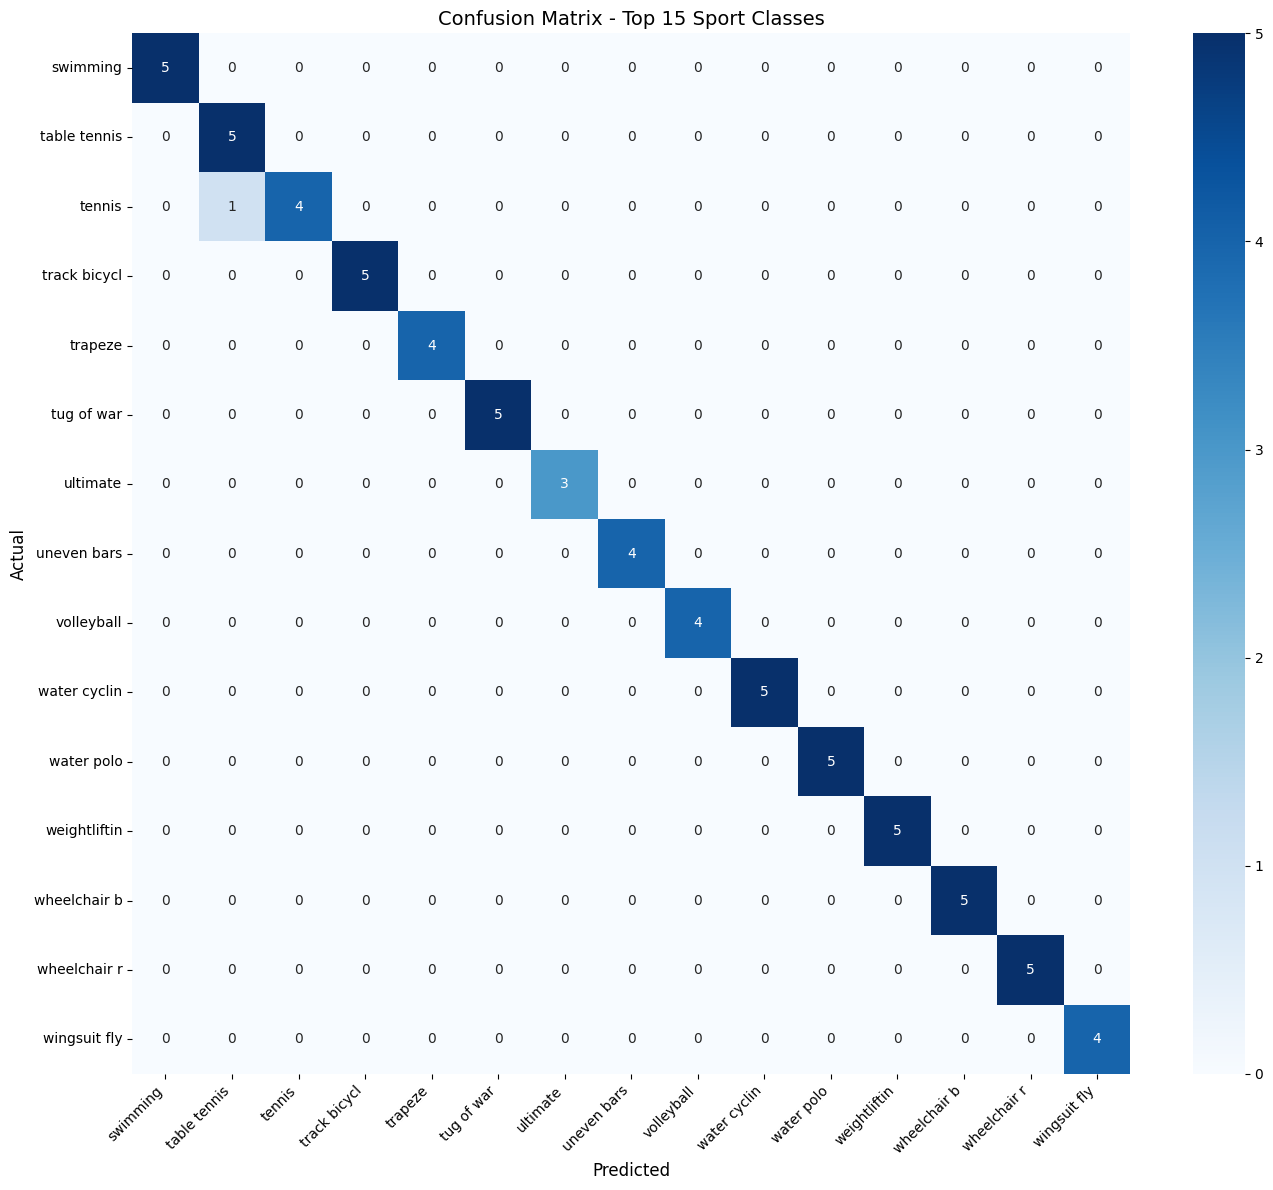

In [ ]:
# Create confusion matrix visualization (top 15 classes for readability)
# Get top 15 most frequent classes in test set
class_counts = np.bincount(y_true)
top_15_classes = np.argsort(class_counts)[-15:]

# Filter predictions for these classes
mask = np.isin(y_true, top_15_classes)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Create confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_15_classes)
class_names_filtered = [class_names[i][:12] for i in top_15_classes]

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_filtered,
            yticklabels=class_names_filtered)
plt.title('Confusion Matrix - Top 15 Sport Classes', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

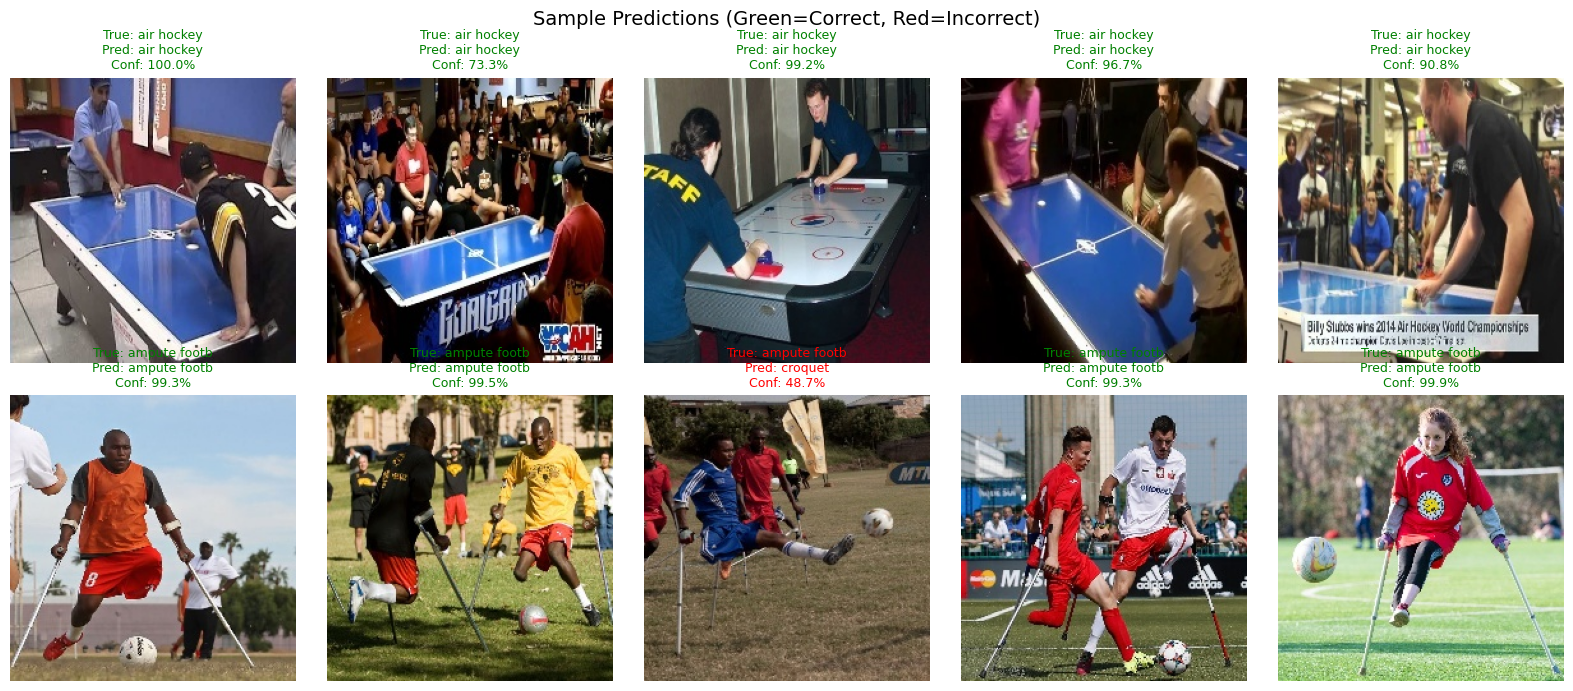

In [ ]:
# Visualize some predictions
fig, axes = plt.subplots(2, 5, figsize=(16, 7))

test_generator.reset()
images, labels = next(test_generator)
predictions = model_cnn.predict(images, verbose=0)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    true_class = class_names[np.argmax(labels[i])]
    pred_class = class_names[np.argmax(predictions[i])]
    confidence = np.max(predictions[i]) * 100

    color = 'green' if true_class == pred_class else 'red'
    ax.set_title(f'True: {true_class[:12]}\nPred: {pred_class[:12]}\nConf: {confidence:.1f}%',
                 fontsize=9, color=color)
    ax.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Summary of optimization techniques used
print("\n" + "="*70)
print("OPTIMIZATION TECHNIQUES APPLIED")
print("="*70)
print("""
1. DATA AUGMENTATION
   - Rotation (±20°), Width/Height shifts (±20%), Horizontal flip
   - Zoom (±20%), Shear (±10%)
   - Purpose: Increase training data variety, reduce overfitting

2. TRANSFER LEARNING (VGG16)
   - Pre-trained on ImageNet (1.2M images, 1000 classes)
   - Leverages learned feature representations
   - Purpose: Better feature extraction with limited data

3. BATCH NORMALIZATION
   - Normalizes layer inputs
   - Purpose: Faster training, acts as regularization

4. DROPOUT REGULARIZATION
   - 50% dropout after first dense layer, 30% after second
   - Purpose: Prevent overfitting by randomly dropping neurons

5. LEARNING RATE SCHEDULING
   - ReduceLROnPlateau: Reduces LR by 50% when val_loss plateaus
   - Purpose: Fine-grained optimization near convergence

6. EARLY STOPPING
   - Monitors val_loss with patience=5
   - Purpose: Prevent overfitting, save training time

7. FINE-TUNING
   - Phase 1: Train only top layers (base frozen)
   - Phase 2: Unfreeze last 4 layers with lower LR
   - Purpose: Adapt pre-trained features to sports domain
""")
print("="*70)


OPTIMIZATION TECHNIQUES APPLIED

1. DATA AUGMENTATION
   - Rotation (±20°), Width/Height shifts (±20%), Horizontal flip
   - Zoom (±20%), Shear (±10%)
   - Purpose: Increase training data variety, reduce overfitting

2. TRANSFER LEARNING (VGG16)
   - Pre-trained on ImageNet (1.2M images, 1000 classes)
   - Leverages learned feature representations
   - Purpose: Better feature extraction with limited data

3. BATCH NORMALIZATION
   - Normalizes layer inputs
   - Purpose: Faster training, acts as regularization

4. DROPOUT REGULARIZATION
   - 50% dropout after first dense layer, 30% after second
   - Purpose: Prevent overfitting by randomly dropping neurons

5. LEARNING RATE SCHEDULING
   - ReduceLROnPlateau: Reduces LR by 50% when val_loss plateaus
   - Purpose: Fine-grained optimization near convergence

6. EARLY STOPPING
   - Monitors val_loss with patience=5
   - Purpose: Prevent overfitting, save training time

7. FINE-TUNING
   - Phase 1: Train only top layers (base frozen)
   - P

In [ ]:
# Final Results Summary
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY - TASK 2a (Part 1): CNN IMAGE CLASSIFICATION")
print("="*70)
print(f"\nDataset: 100 Sports Image Classification")
print(f"Link: https://www.kaggle.com/datasets/gpiosenka/sports-classification")
print(f"Total Images: {train_count + valid_count + test_count}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"\nModel: VGG16 Transfer Learning with Fine-tuning")
print(f"\nClassification Results:")
print(f"  Accuracy:  {cnn_accuracy:.4f}")
print(f"  Precision: {cnn_precision:.4f}")
print(f"  Recall:    {cnn_recall:.4f}")
print(f"  F1-Score:  {cnn_f1:.4f}")
print(f"  AUC-ROC:   {cnn_auc:.4f}")
print("="*70)


FINAL RESULTS SUMMARY - TASK 2a (Part 1): CNN IMAGE CLASSIFICATION

Dataset: 100 Sports Image Classification
Link: https://www.kaggle.com/datasets/gpiosenka/sports-classification
Total Images: 14492
Number of Classes: 100

Model: VGG16 Transfer Learning with Fine-tuning

Classification Results:
  Accuracy:  0.9040
  Precision: 0.9180
  Recall:    0.9040
  F1-Score:  0.9004
  AUC-ROC:   0.9995


---
# ═══════════════════════════════════════════════════════════════
# TASK 2a PART 1: CNN IMAGE CLASSIFICATION (100 Sports)
# ═══════════════════════════════════════════════════════════════

### What it predicts:
- **INPUT**: An image of a sport
- **OUTPUT**: Which sport category (e.g., "basketball", "swimming", "football")

### Real-world use:
- Auto-tagging sports images on social media
- Organizing sports photo libraries
- Content moderation for sports platforms

---

In [ ]:
# ════════════════════════════════════════════════════════════════
# TASK 2a CNN: PREDICTION INTERPRETATION SECTION
# Add this to the END of your CNN notebook (after model training)
# ════════════════════════════════════════════════════════════════

# Note: This assumes you have:
# - 'model' = your trained CNN model
# - 'test_generator' = your test data generator
# - 'class_names' = list of sport categories

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

SAMPLE PREDICTIONS: What sport does the model see in each image?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


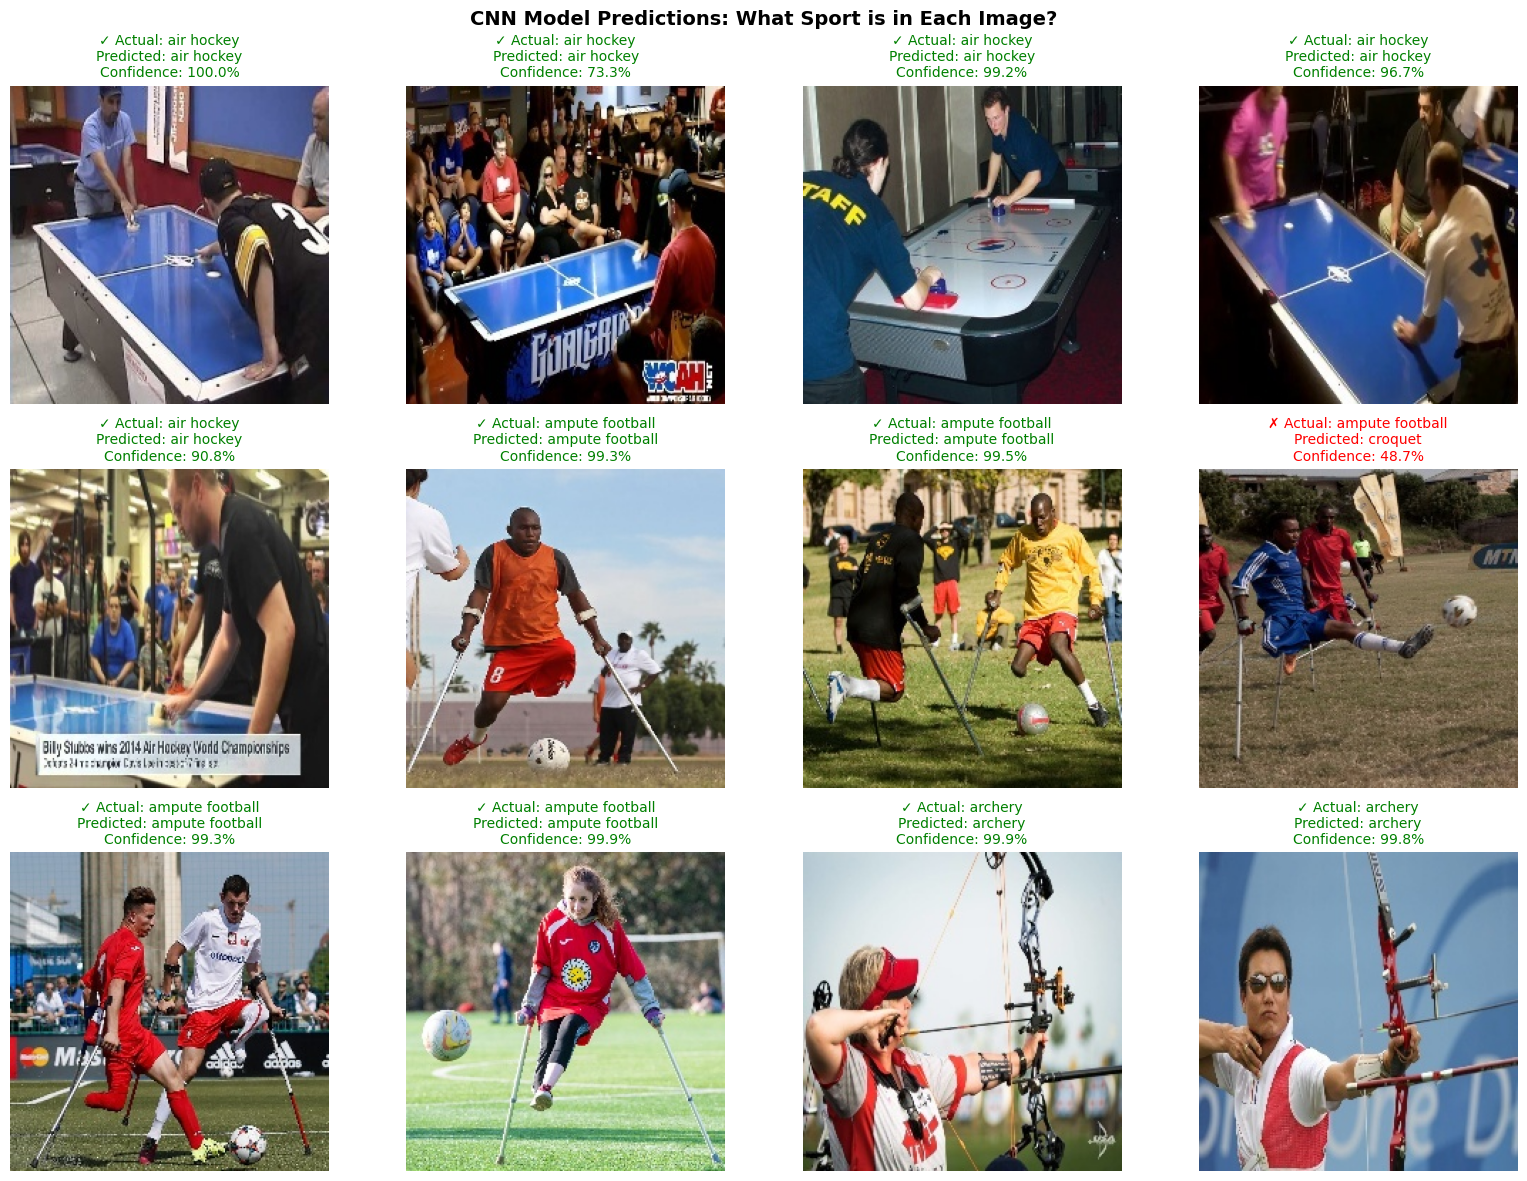

In [ ]:
# ════════════════════════════════════════════════════════════════
# SHOW SAMPLE PREDICTIONS WITH IMAGES
# ════════════════════════════════════════════════════════════════

def show_predictions_with_images(model, test_generator, class_names, num_samples=12):
    """
    Display sample images with their actual and predicted labels.
    """
    # Get a batch of test images
    test_generator.reset()
    images, labels = next(test_generator)

    # Make predictions
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(labels, axis=1) if len(labels.shape) > 1 else labels

    # Plot images with predictions
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for i in range(min(num_samples, len(images))):
        ax = axes[i]
        ax.imshow(images[i])

        actual = class_names[actual_classes[i]]
        predicted = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100

        # Color code: green for correct, red for incorrect
        color = 'green' if actual == predicted else 'red'
        symbol = '✓' if actual == predicted else '✗'

        ax.set_title(f"{symbol} Actual: {actual}\nPredicted: {predicted}\nConfidence: {confidence:.1f}%",
                     fontsize=10, color=color)
        ax.axis('off')

    plt.suptitle('CNN Model Predictions: What Sport is in Each Image?', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run the visualization
print("="*80)
print("SAMPLE PREDICTIONS: What sport does the model see in each image?")
print("="*80)
show_predictions_with_images(model_cnn, test_generator, class_names)

In [ ]:
# ════════════════════════════════════════════════════════════════
# FUNCTION TO PREDICT SPORT FROM ANY NEW IMAGE
# ════════════════════════════════════════════════════════════════

from tensorflow.keras.preprocessing import image
from PIL import Image
import requests
from io import BytesIO

def predict_sport_from_image(img_path_or_url, model, class_names, img_size=(224, 224)):
    """
    Predict what sport is shown in an image.

    Args:
        img_path_or_url: Local file path or URL to image
        model: Trained CNN model
        class_names: List of sport category names
        img_size: Expected input size for the model

    Returns:
        predicted_sport: Name of the predicted sport
        confidence: Confidence percentage
    """
    # Load image
    if img_path_or_url.startswith('http'):
        response = requests.get(img_path_or_url)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(img_path_or_url)

    # Preprocess
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0
    if len(img_array.shape) == 2:  # Grayscale
        img_array = np.stack([img_array] * 3, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    predicted_sport = class_names[predicted_idx]
    confidence = predictions[0][predicted_idx] * 100

    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"*** PREDICTED SPORT: {predicted_sport.upper()} ***\nConfidence: {confidence:.1f}%",
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Show top 5 predictions
    print("\nTop 5 Sport Predictions:")
    top_5_idx = np.argsort(predictions[0])[-5:][::-1]
    for idx in top_5_idx:
        prob = predictions[0][idx] * 100
        bar = '█' * int(prob / 3)
        print(f"  {class_names[idx]:<20}: {bar} {prob:.1f}%")

    return predicted_sport, confidence

print("Function 'predict_sport_from_image' created!")
print("Usage: predict_sport_from_image('path/to/image.jpg', model, class_names)")

Function 'predict_sport_from_image' created!
Usage: predict_sport_from_image('path/to/image.jpg', model, class_names)


In [ ]:
# ════════════════════════════════════════════════════════════════
# FUNCTION TO PREDICT SPORT FROM ANY NEW IMAGE
# ════════════════════════════════════════════════════════════════

from tensorflow.keras.preprocessing import image
from PIL import Image
import requests
from io import BytesIO

def predict_sport_from_image(img_path_or_url, model, class_names, img_size=(224, 224)):
    """
    Predict what sport is shown in an image.

    Args:
        img_path_or_url: Local file path or URL to image
        model: Trained CNN model
        class_names: List of sport category names
        img_size: Expected input size for the model

    Returns:
        predicted_sport: Name of the predicted sport
        confidence: Confidence percentage
    """
    # Load image
    if img_path_or_url.startswith('http'):
        response = requests.get(img_path_or_url)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(img_path_or_url)

    # Preprocess
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0
    if len(img_array.shape) == 2:  # Grayscale
        img_array = np.stack([img_array] * 3, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    predicted_sport = class_names[predicted_idx]
    confidence = predictions[0][predicted_idx] * 100

    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"*** PREDICTED SPORT: {predicted_sport.upper()} ***\nConfidence: {confidence:.1f}%",
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Show top 5 predictions
    print("\nTop 5 Sport Predictions:")
    top_5_idx = np.argsort(predictions[0])[-5:][::-1]
    for idx in top_5_idx:
        prob = predictions[0][idx] * 100
        bar = '█' * int(prob / 3)
        print(f"  {class_names[idx]:<20}: {bar} {prob:.1f}%")

    return predicted_sport, confidence

print("Function 'predict_sport_from_image' created!")
print("Usage: predict_sport_from_image('path/to/image.jpg', model, class_names)")

Function 'predict_sport_from_image' created!
Usage: predict_sport_from_image('path/to/image.jpg', model, class_names)


In [ ]:
# ════════════════════════════════════════════════════════════════
# FINAL SUMMARY - CNN IMAGE CLASSIFICATION
# ════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("FINAL SUMMARY - TASK 2a: CNN IMAGE CLASSIFICATION")
print("="*80)
print(f"\nDataset: 100 Sports Image Classification")
print(f"Model: VGG16 Transfer Learning + Custom Dense Layers")
print(f"\n🎯 PREDICTION TASK:")
print(f"   INPUT:  An image of a sport being played")
print(f"   OUTPUT: Which sport it is (e.g., 'basketball', 'swimming', 'football')")
print(f"\n📊 MODEL PERFORMANCE:")
print(f"   Test Accuracy: {cnn_accuracy*100:.2f}%")
print(f"\n💡 INTERPRETATION:")
print(f"   - Model correctly identifies sports {cnn_accuracy*100:.1f}% of the time")
print(f"   - Works best on: Clear, well-lit images with visible sport activity")
print(f"   - Use case: Auto-tagging sports photos, content moderation")
print("="*80)


FINAL SUMMARY - TASK 2a: CNN IMAGE CLASSIFICATION

Dataset: 100 Sports Image Classification
Model: VGG16 Transfer Learning + Custom Dense Layers

🎯 PREDICTION TASK:
   INPUT:  An image of a sport being played
   OUTPUT: Which sport it is (e.g., 'basketball', 'swimming', 'football')

📊 MODEL PERFORMANCE:
   Test Accuracy: 90.40%

💡 INTERPRETATION:
   - Model correctly identifies sports 90.4% of the time
   - Works best on: Clear, well-lit images with visible sport activity
   - Use case: Auto-tagging sports photos, content moderation
